In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, opening, closing
import glob
import pathlib

In [157]:
rpi = 'h2r3'

# Read input image and resize them
path_to_folder = '../live_bees/' + rpi + '/random_images_25/*.jpg'
folder_in = sorted(glob.glob(path_to_folder))
names = [pathlib.Path(x).stem for x in folder_in]

folder_out = 'resized_images/' + rpi + '/'
n = 0
for img_path in folder_in:
    cv2.imwrite(folder_out + str(names[n]) + '.jpg', cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY), (0,0), fx=0.5, fy=0.5));
    n += 1

resized_imgs_path = sorted(glob.glob(folder_out + '*.jpg'))
print(cv2.imread(resized_imgs_path[0]).shape)

(1296, 2304, 3)


# Run this cell only if you want to batch process using ilastik

In [122]:
resized_imgs_path = sorted(glob.glob(folder_out + '*.jpg'))

ILASTIK_PATH = '/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/run_ilastik.sh'
MODEL='trained_model.ilp'
IMG = ''
OUTPUT_FORMAT = 'bmp'
OUTPUT_FOLDER = './segmentation/'+ rpi + '/{nickname}_mask.bmp'
for img_path in resized_imgs_path:
    IMG += img_path + ' '
# we call ilastik as headless operation on the pc
!$ILASTIK_PATH  --headless \
                --project=$MODEL \
                --export_source='simple segmentation' \
                --output_format=$OUTPUT_FORMAT \
                --output_filename_format=$OUTPUT_FOLDER \
                $IMG

INFO ilastik.app: Using tiktorch executable: ['/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/bin/python', '-m', 'tiktorch.server']
INFO ilastik.app: config file location: <none>
INFO ilastik.app: Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
WARNING 2024-05-30 15:36:47,303 opConservationTracking 46378 4656752128 Could not find any ILP solver
WARNING 2024-05-30 15:36:47,342 opStructuredTracking 46378 4656752128 Could not find any ILP solver
WARNING 2024-05-30 15:36:47,345 structuredTrackingWorkflow 46378 4656752128 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!
INFO ilastik.shell.projectManager: Opening Project: trained_model.ilp
INFO ilastik.workflows.pixelClassification.pixelClassifica

# Post processessing

In [158]:
path_to_segmented = sorted(glob.glob('segmentation/' + rpi + '/*.bmp'))
path_to_processed = '../a_processed_images/ilastik/' + rpi + '/'
segmented_imgs = []
for path in path_to_segmented:
    segmented_imgs.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
n = 0
processed_imgs = []
for mask in segmented_imgs:
    mask_open = opening(mask, disk(5))
    mask_closed = closing(mask_open, disk(5))
    processed_imgs.append(mask_closed)
    cv2.imwrite(path_to_processed + names[n] + '.bmp', mask_closed)
    n += 1

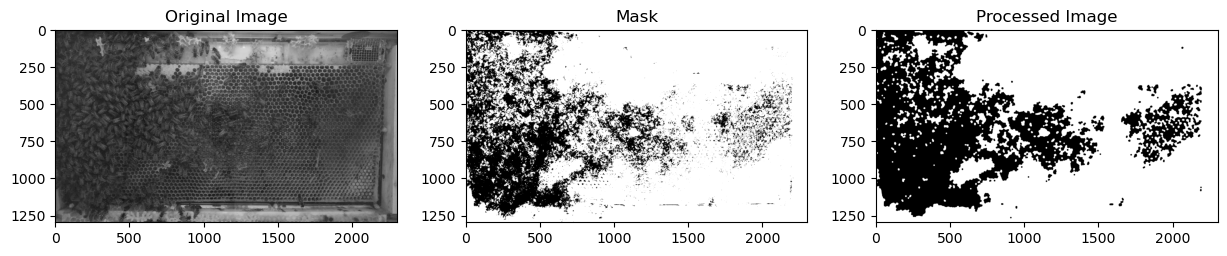

In [159]:
# show the processed image next to the original and the mask
img_number = 14
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(cv2.imread(resized_imgs_path[img_number], cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(segmented_imgs[img_number], cmap='gray')
plt.title('Mask')
plt.subplot(133)
plt.imshow(processed_imgs[img_number], cmap='gray')
plt.title('Processed Image')
plt.show()

In [160]:
resized_imgs = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in sorted(glob.glob('resized_images/' + rpi + '/*.jpg'))]
processed_imgs = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in sorted(glob.glob('../a_processed_images/ilastik/' + rpi + '/*.bmp'))]
masks = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in sorted(glob.glob('segmentation/' + rpi + '/*.bmp'))]

for mask, input_image in zip(processed_imgs, resized_imgs):
    mask = cv2.threshold(mask, 1.5, 255, cv2.THRESH_BINARY)[1]
    img_contour = (~mask).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
    contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    contours = [x for x in contours if cv2.contourArea(x) > 120000]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2] #get the 2 biggest contour
    img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
    cv2.drawContours(input_image, contours, -1, (255, 0, 0), 7) #draw the biggest contour
    print('-------')
    # find the centroid of the contour
    for contour in contours:
        print(cv2.contourArea(contour))
    #     M = cv2.moments(contour)
    #     cX = int(M["m10"] / M["m00"])
    #     cY = int(M["m01"] / M["m00"])
    #     cv2.circle(input_image, (cX, cY), 10, (255, 0, 0), -1)
    #     cv2.putText(input_image, "centroid", (cX - 30, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 7)

-------
289702.0
-------
1394660.5
-------
1317334.5
-------
990897.0
246645.0
-------
1232199.0
263556.0
-------
1179143.5
252468.0
-------
1423880.0
-------
1224466.0
287662.0
-------
1170092.5
295245.5
-------
1277228.5
234461.0
-------
1324495.0
271531.5
-------
1335036.0
259707.0
-------
1304022.5
269147.5
-------
1202078.5
277417.0
-------
1015292.0
-------
861014.0
-------
997661.5
-------
839323.0
134300.5
-------
951017.5
-------
866616.0


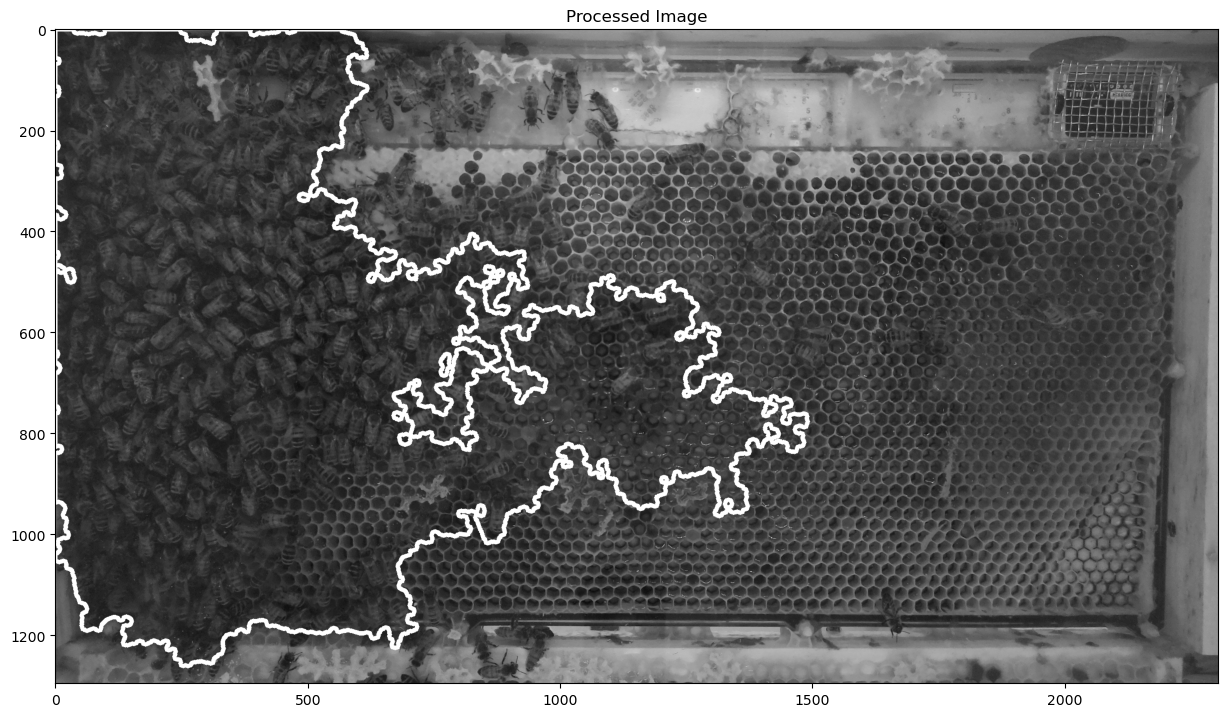

In [161]:
# show the processed image next to the original and the mask
img_number = 14
plt.figure(figsize=(15, 15))
plt.imshow(resized_imgs[img_number], cmap='gray')
plt.title('Processed Image')
plt.show()